In [1]:
import pandas as pd
import  missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
import yaml
from ydata_profiling import ProfileReport

# ! git clone https://github.com/tikendraw/funcyou.git -q

from funcyou.metrics import calculate_results
from funcyou.grid_search_utils import plot_grid_search, table_grid_search
import scipy.stats as stats
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder , StandardScaler, PowerTransformer, LabelBinarizer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix  
from imblearn.over_sampling import SMOTE 


In [2]:
data = pd.read_csv('./input/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(data.shape)

(7043, 21)


In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(data['SeniorCitizen'].value_counts())
data['SeniorCitizen'] = data['SeniorCitizen'].map({0:'No',1: 'Yes'})
print(data['SeniorCitizen'].value_counts())


0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64


In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

No     5174
Yes    1869
Name: churn, dtype: int64


<AxesSubplot: xlabel='churn', ylabel='count'>

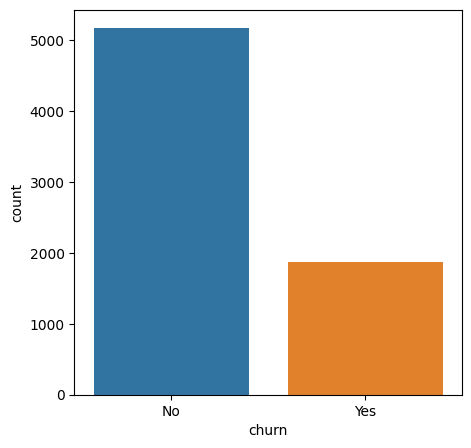

In [6]:
print(data.churn.value_counts())
plt.figure(figsize = (5,5))
sns.countplot(data = data, x='churn', orient='v')


Quite Imbalanced data, we will use 1. Undersampling and 2. Oversampling Technique to overcome class imbalance

In [7]:
data.dtypes

customerid           object
gender               object
seniorcitizen        object
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [8]:
# lowering the string data
for col in data.select_dtypes(include = 'object'):
    data[col] = data[col].str.lower()

In [9]:
for col in data.columns:
    if data[col].nunique() < 50000:
        print(f'{data[col].name :30} :{str(data[col].dtype) :10}  : {data[col].nunique():5} ')
        # print(data[col].unique())
    # print(col)
    

customerid                     :object      :  7043 
gender                         :object      :     2 
seniorcitizen                  :object      :     2 
partner                        :object      :     2 
dependents                     :object      :     2 
tenure                         :int64       :    73 
phoneservice                   :object      :     2 
multiplelines                  :object      :     3 
internetservice                :object      :     3 
onlinesecurity                 :object      :     3 
onlinebackup                   :object      :     3 
deviceprotection               :object      :     3 
techsupport                    :object      :     3 
streamingtv                    :object      :     3 
streamingmovies                :object      :     3 
contract                       :object      :     3 
paperlessbilling               :object      :     2 
paymentmethod                  :object      :     4 
monthlycharges                 :float64     : 

So there are mostly columns with 2, 3 and 4 categorical values, we will be separating 2 categorical values columns to rest for transformation in later stages 

In [10]:
# Droping Duplicates
data.drop_duplicates(inplace = True)

In [11]:
# Droping customerid(unique values)
data.drop('customerid', axis = 1, inplace = True)

## Observations

1. There are no null values
2. Data is mostly categorical

Columns 'totalcharges' is numeric but due to some string imputation whole columns is seen as object type. We will replace it with `nans`

In [12]:
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors='coerce', downcast='float')

In [13]:
data[data['totalcharges'].isnull()]


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,female,no,yes,yes,0,no,no phone service,dsl,yes,no,yes,yes,yes,no,two year,yes,bank transfer (automatic),52.55,NaN,no
753,male,no,no,yes,0,yes,no,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,two year,no,mailed check,20.25,NaN,no
936,female,no,yes,yes,0,yes,no,dsl,yes,yes,yes,no,yes,yes,two year,no,mailed check,80.85,NaN,no
1082,male,no,yes,yes,0,yes,yes,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,two year,no,mailed check,25.75,NaN,no
1340,female,no,yes,yes,0,no,no phone service,dsl,yes,yes,yes,yes,yes,no,two year,no,credit card (automatic),56.05,NaN,no
3331,male,no,yes,yes,0,yes,no,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,two year,no,mailed check,19.85,NaN,no
3826,male,no,yes,yes,0,yes,yes,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,two year,no,mailed check,25.35,NaN,no
4380,female,no,yes,yes,0,yes,no,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,two year,no,mailed check,20.00,NaN,no
5218,male,no,yes,yes,0,yes,no,no,no internet service,no internet service,no internet service,no internet service,no internet service,no internet service,one year,yes,mailed check,19.70,NaN,no
6670,female,no,yes,yes,0,yes,yes,dsl,no,yes,yes,yes,yes,no,two year,no,mailed check,73.35,NaN,no


In above dataframe we see that there are no entry for totalcharges

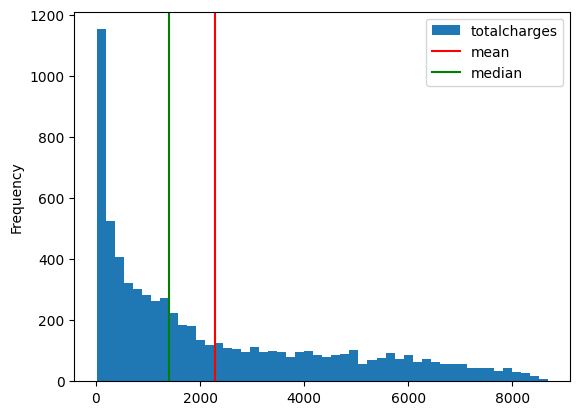

In [14]:
data['totalcharges'].plot(kind='hist', bins = 50)
plt.axvline(x = data['totalcharges'].mean(),color = 'r', label = 'mean')
plt.axvline(x = data['totalcharges'].median(),color = 'g', label = 'median')
plt.legend()

In [15]:
data[data['totalcharges'].isnull()]['churn']


488     no
753     no
936     no
1082    no
1340    no
3331    no
3826    no
4380    no
5218    no
6670    no
6754    no
Name: churn, dtype: object

Since we have a very imabalance dataset, and this nan values rows aren't cotributing much we will drop them

In [16]:
data.isnull().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [17]:
data.dropna( inplace = True)

In [18]:
data.isnull().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [19]:
data.shape # before it was 7043

(7032, 20)

## Numerical and Categorial Columns

In [20]:
# Categorial columns
categorial_columns = [col for col in data.columns if data[col].nunique() < 10]
        

 >So there are mostly columns with 2, 3 and 4 categorical values, we will be separating 2 categorical values columns to rest for transformation in later stages 

In [21]:
# Categorial columns
two_value_categorial_columns = [
    col for col in categorial_columns if data[col].nunique() == 2
]
print(two_value_categorial_columns)


['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paperlessbilling', 'churn']


In [22]:

more_value_categorial_columns = [col for col in categorial_columns if col not in two_value_categorial_columns]

In [23]:
        
two_value_categorial_columns.remove('churn')

print(two_value_categorial_columns)
print(more_value_categorial_columns)



['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']
['multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paymentmethod']


In [24]:
# Numerical Columns
numerical_columns = [col for col in data.columns if col not in categorial_columns]

In [25]:
print(f"{numerical_columns = }")
print(f"{categorial_columns = }")

print(len(numerical_columns), len(categorial_columns), len(data.columns))

numerical_columns = ['tenure', 'monthlycharges', 'totalcharges']
categorial_columns = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']
3 17 20


In [26]:
# Saving categorical values with category (would be helpful for building the app)
categories_with_values = {}

for col in categorial_columns:
    if col != 'churn':
        categories_with_values[col] = list(data[col].unique())    
    

In [27]:
categories_with_values

{'gender': ['female', 'male'],
 'seniorcitizen': ['no', 'yes'],
 'partner': ['yes', 'no'],
 'dependents': ['no', 'yes'],
 'phoneservice': ['no', 'yes'],
 'multiplelines': ['no phone service', 'no', 'yes'],
 'internetservice': ['dsl', 'fiber optic', 'no'],
 'onlinesecurity': ['no', 'yes', 'no internet service'],
 'onlinebackup': ['yes', 'no', 'no internet service'],
 'deviceprotection': ['no', 'yes', 'no internet service'],
 'techsupport': ['no', 'yes', 'no internet service'],
 'streamingtv': ['no', 'yes', 'no internet service'],
 'streamingmovies': ['no', 'yes', 'no internet service'],
 'contract': ['month-to-month', 'one year', 'two year'],
 'paperlessbilling': ['yes', 'no'],
 'paymentmethod': ['electronic check',
  'mailed check',
  'bank transfer (automatic)',
  'credit card (automatic)']}

# Analysis

In [28]:
# design_report = ProfileReport(data)
# design_report.to_file(output_file='data_report.html')

## Correlation

In [29]:
# ordinal encoding  categorical values to plot correlation
ord_encoder = OrdinalEncoder()
df = data.copy()
for col in categorial_columns:
    df[col] = ord_encoder.fit_transform(df[col].values.reshape(-1, 1))

In [30]:
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,29.850000,0.0
1,1.0,0.0,0.0,0.0,34,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,1889.500000,0.0
2,1.0,0.0,0.0,0.0,2,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,108.150002,1.0
3,1.0,0.0,0.0,0.0,45,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,1840.750000,0.0
4,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,151.649994,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,24,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,84.80,1990.500000,0.0
7039,0.0,0.0,1.0,1.0,72,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,103.20,7362.899902,0.0
7040,0.0,0.0,1.0,1.0,11,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.60,346.450012,0.0
7041,1.0,1.0,1.0,0.0,4,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,74.40,306.600006,1.0


<AxesSubplot: >

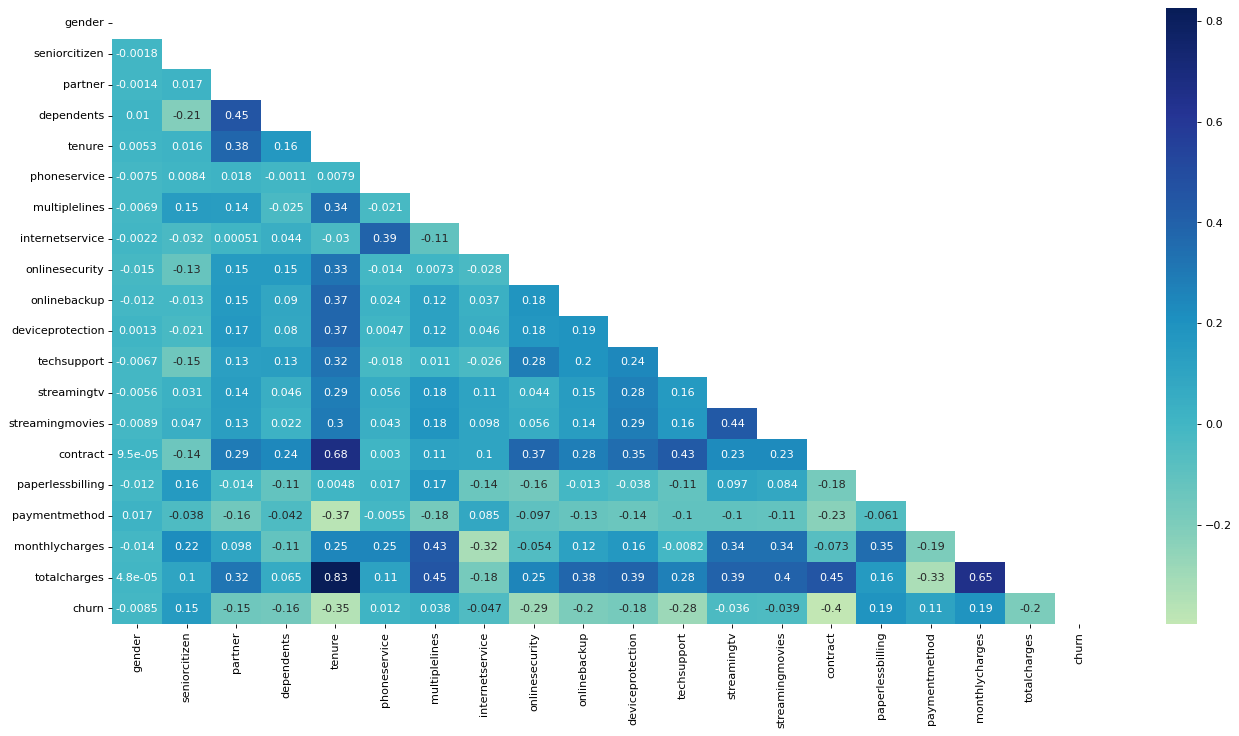

In [31]:
mask = np.triu(np.ones_like(df.corr()))
fig, ax = plt.subplots(figsize=(20,10),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), mask= mask, cmap="YlGnBu", annot = True, center = 0,annot_kws={"fontsize":10})

<AxesSubplot: >

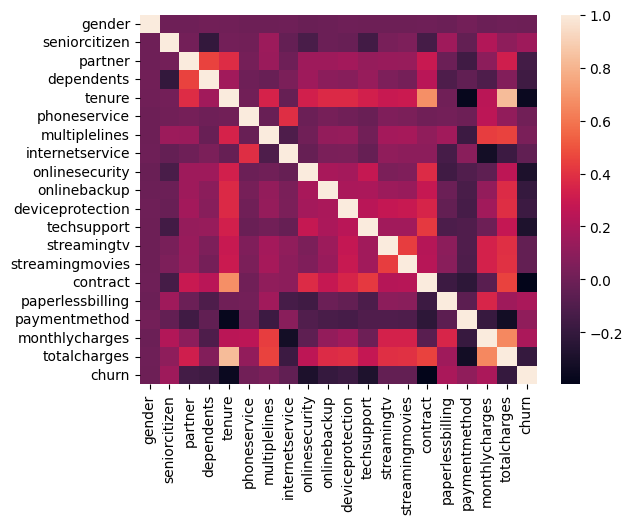

In [32]:
sns.heatmap(df.corr())

In [33]:
df['churn'].value_counts()/len(df)*100

0.0    73.421502
1.0    26.578498
Name: churn, dtype: float64

<AxesSubplot: >

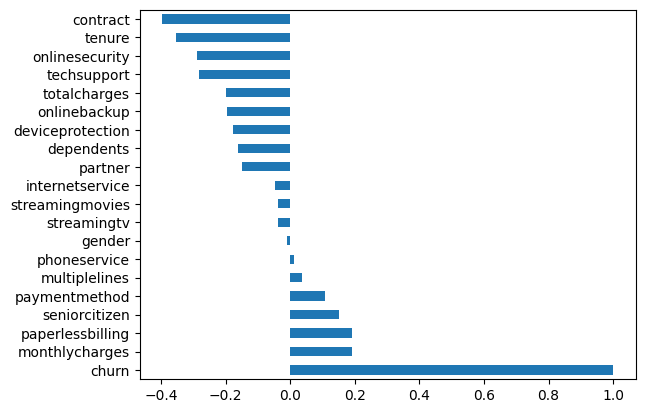

In [34]:
df.corr()['churn'].sort_values(ascending = False).plot(kind='barh')

## Distribution

### 1.  Categorial Columns

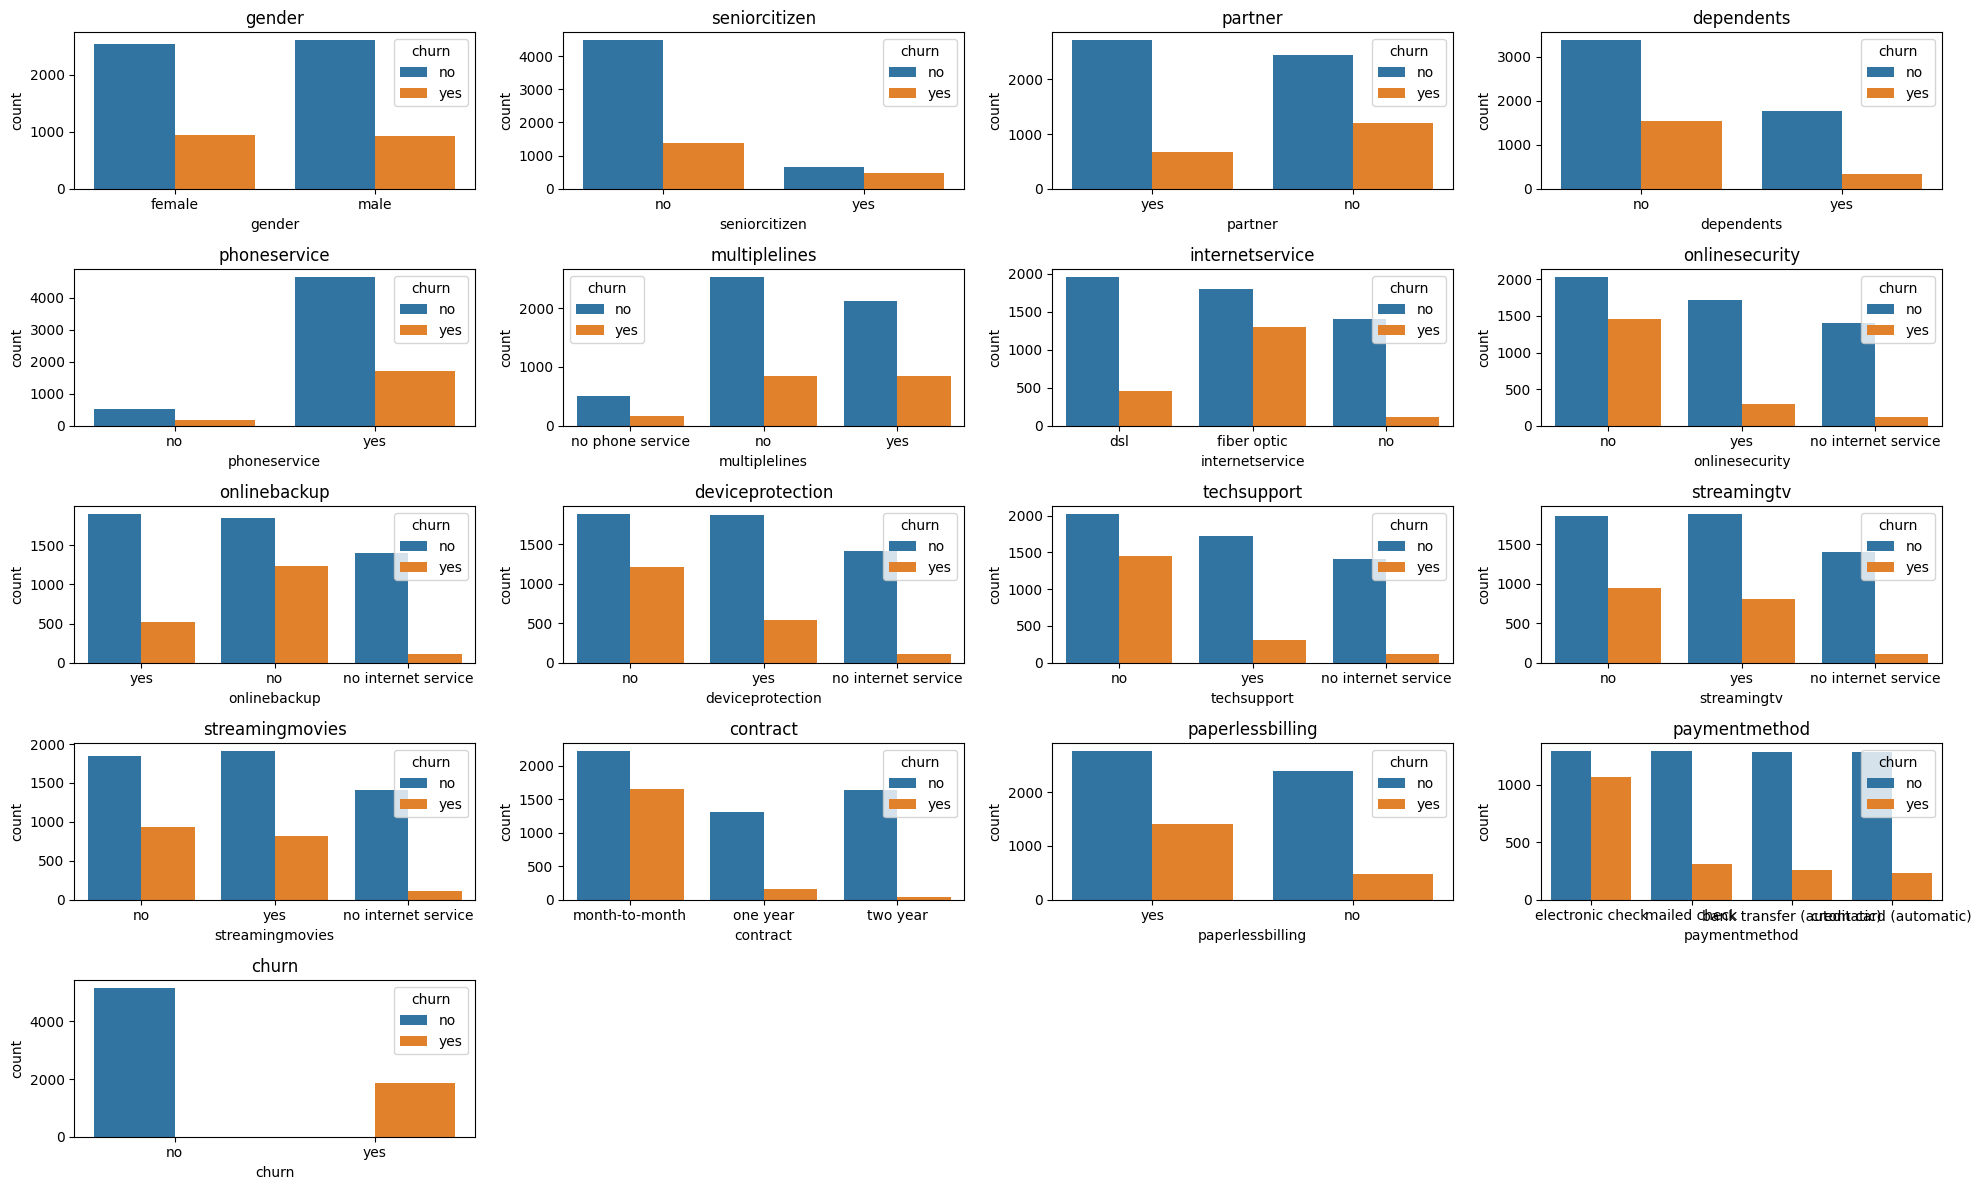

In [35]:
plt.figure(figsize = (20,12))
for n, col in enumerate(categorial_columns,1):
    plt.subplot(5,4,n)
    sns.countplot(data = data, x=col, hue='churn')
    plt.title(col)
plt.tight_layout()

### 2. Numbercal columns

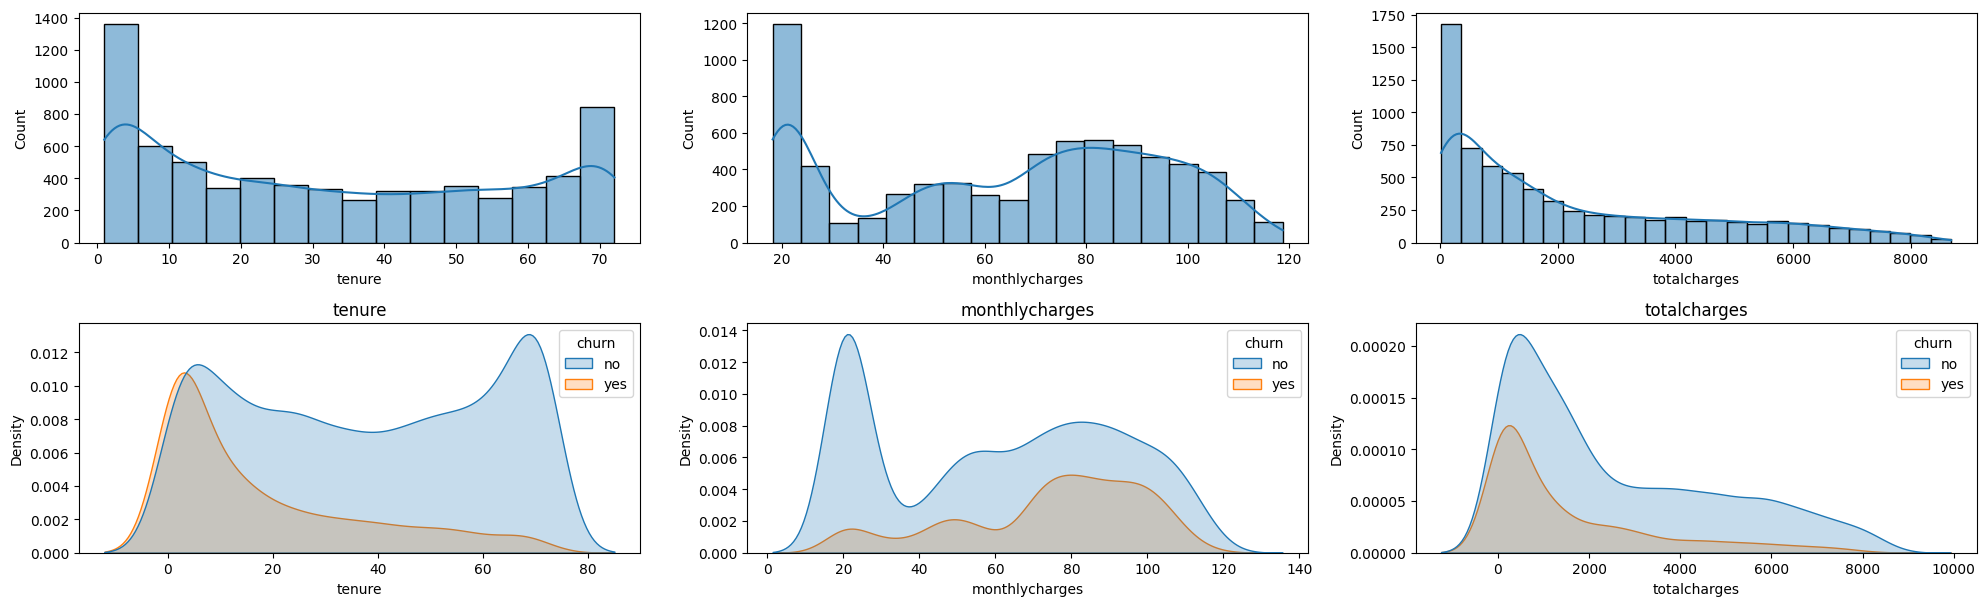

In [36]:
plt.figure(figsize = (20,15))
for n, col in enumerate(numerical_columns,1):
    # print('plotting', col)
    plt.subplot(5,3,n)
    sns.histplot(x=data[col],fill=True, kde=True)
    
    plt.subplot(5,3,n+3)
    sns.kdeplot(x=data[col],fill=True, hue = data['churn'])
    
    plt.title(col)
    
plt.tight_layout()

## Outlier check

In [37]:
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers\n")
    else:
        print("From grubbs_test we observe that calculated value is greater than critical value, Reject null hypothesis and conclude that there is an outliers\n")


In [38]:
for col in numerical_columns:
    grubbs_test(data[col])

Grubbs Calculated Value: 1.6125732136881425
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers

Grubbs Calculated Value: 1.7933814803098413
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers

Grubbs Calculated Value: 2.824261218317251
Grubbs Critical Value: 4.4872995984066515
From grubbs_test we observe that calculated value is lesser than critical value, Accept null hypothesis and conclude that there is no outliers



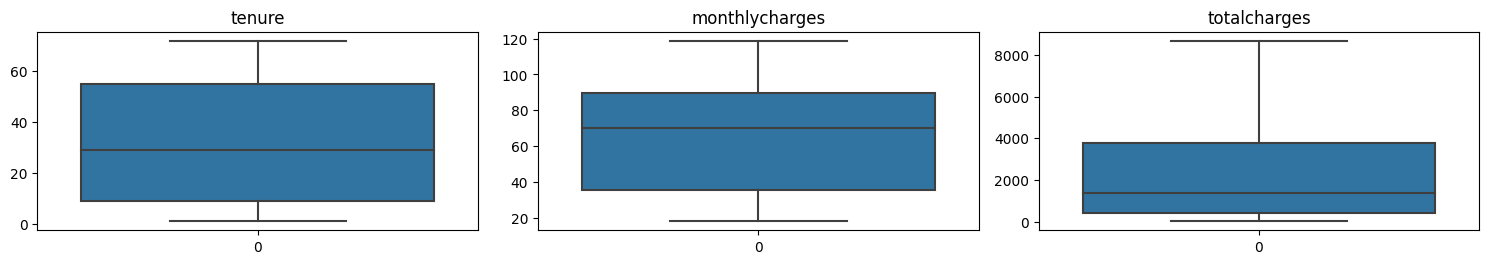

In [39]:
plt.figure(figsize = (20,12))
for n, col in enumerate(numerical_columns,1):
    # print('plotting', col)
    plt.subplot(5,4,n)
    sns.boxplot(data[col])
    
    plt.title(col)
    
plt.tight_layout()

# Test 1 (Undersampling)

## Preprocessing

In [40]:
# balanceing the data (undersampling)
print(data.churn.value_counts())

no     5163
yes    1869
Name: churn, dtype: int64


In [41]:
churn_no = data[data['churn'] =='no'].sample(1869)
churn_yes = data[data['churn'] == 'yes']

#compbining equal number of samples
x = pd.concat([churn_no, churn_yes], axis=0)

In [42]:
churn_no.shape, churn_yes.shape, x.shape

((1869, 20), (1869, 20), (3738, 20))

In [43]:
# Setting features and encoding response
le = LabelEncoder()
y = le.fit_transform(y = x['churn'])
x = x.drop('churn',axis = 1)

In [44]:
le.classes_

array(['no', 'yes'], dtype=object)

In [45]:
categorial_columns.remove('churn')

In [46]:
# Preprocessing all columns 
column_transformer = ColumnTransformer([
    ('onehot',OneHotEncoder(sparse=False, drop='first'),two_value_categorial_columns), 
    ('ordinal', OrdinalEncoder(), more_value_categorial_columns),
    ('power_transform', PowerTransformer(),numerical_columns)
], remainder='passthrough', n_jobs = -1)

In [47]:
# transform the dataset
x = column_transformer.fit_transform(x)


In [48]:
x.shape, y.shape, np.bincount(y)

((3738, 19), (3738,), array([1869, 1869]))

## Model training and Testing

In [49]:

clf = {
    'Nearest Neighbors':KNeighborsClassifier(),
    'Logistic Regression':LogisticRegression(),
    'Linear SVM':SVC(C=0.025, kernel='linear'),
    # 'RBF SVM':SVC(C=1, gamma=2),
    # 'Gaussian Process':GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)),
    'Decision Tree':DecisionTreeClassifier(max_depth=5),
    'Random Forest':RandomForestClassifier(max_depth=5, n_estimators=10),
    'Neural Net':MLPClassifier(alpha=1, max_iter=1000),
    'AdaBoost':AdaBoostClassifier(),
    'Naive Bayes':GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
    'XGBC':XGBClassifier(),
    'XGBRF':XGBRFClassifier()
}

In [50]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score),"precision": make_scorer(precision_score),"recall": make_scorer(recall_score),"f1": make_scorer(f1_score)}


In [51]:
all_model_results = []

for name, model in clf.items():
    print('Training :', name)
    # model.fit(x, y)
    scores_ = cross_validate(model, x, y, cv = 5, n_jobs=-1, verbose = 0, scoring=scoring)
    # ypred = model.predict(xts)
    scores_['model'] = name
    scores_['test'] = 'test1'
    all_model_results.append(scores_)
    
    # all_model_results.append(calculate_results(ytest, ypred, model_name=name))

Training : Nearest Neighbors
Training : Logistic Regression
Training : Linear SVM
Training : Decision Tree
Training : Random Forest
Training : Neural Net
Training : AdaBoost
Training : Naive Bayes
Training : QDA
Training : XGBC
Training : XGBRF


In [52]:
# all_model_results

In [53]:
# all metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

In [54]:
test1 = pd.DataFrame(all_model_results)
test1.set_index = test1.model
# test1.style.highlight_max(color = 'lightgreen', subset = metrics)

for col in test1.columns:
    try:
        test1[col] = test1[col].apply(lambda x: np.mean(x))
    except:
        pass

# 

# Defining custom function which returns 
# the list for df.style.apply() method
def highlight_max(s):
    is_max = s == s.max()
    return ['color: green' if cell else '' for cell in is_max]
  
test1.style.apply(highlight_max)

,fit_time,score_time,test_AUC,test_Accuracy,test_precision,test_recall,test_f1,model,test
0,0.001034,0.091676,0.771851,0.708132,0.691453,0.752260,0.720335,Nearest Neighbors,test1
1,0.026490,0.006065,0.847025,0.762170,0.747498,0.793458,0.769267,Logistic Regression,test1
2,0.223226,0.062965,0.846064,0.754147,0.729557,0.809514,0.766976,Linear SVM,test1
3,0.014380,0.007347,0.815167,0.739163,0.721851,0.779563,0.749211,Decision Tree,test1
4,0.029567,0.008561,0.835085,0.751739,0.736542,0.784896,0.759702,Random Forest,test1
5,1.287109,0.005821,0.843803,0.754949,0.746250,0.774205,0.759396,Neural Net,test1
6,0.195755,0.029916,0.841728,0.761370,0.739876,0.806839,0.771628,AdaBoost,test1
7,0.002571,0.007291,0.831223,0.756287,0.735918,0.799890,0.766448,Naive Bayes,test1
8,0.010030,0.008703,0.833258,0.752272,0.731662,0.797749,0.762925,QDA,test1
9,0.432369,0.008728,0.808326,0.732742,0.726238,0.747450,0.736402,XGBC,test1


# Test 2 (Oversampling)

In [55]:
column_transformer.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['gender', 'seniorcitizen', 'partner',
                                  'dependents', 'phoneservice',
                                  'paperlessbilling']),
                                ('ordinal', OrdinalEncoder(),
                                 ['multiplelines', 'internetservice',
                                  'onlinesecurity', 'onlinebackup',
                                  'deviceprotection', 'techsupport',
                                  'streamingtv', 'streamingmovies', 'contract',
                                  'paymentmethod']),
                                ('power_transform', PowerTransformer(),
                                 ['tenure', 'monthlycharges', 'totalcharges'])])>

In [56]:
column_transformer.feature_names_in_

array(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges'], dtype=object)

## Preprocessing

In [57]:
# balanceing the data (undersampling)
print(data.churn.value_counts())

no     5163
yes    1869
Name: churn, dtype: int64


In [58]:
two_value_categorial_columns

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'paperlessbilling']

In [59]:
# Preprocessing all columns 
column_transformer = ColumnTransformer([
    ('onehot',OneHotEncoder(sparse=False, drop='first'),two_value_categorial_columns), 
    ('ordinal', OrdinalEncoder(), more_value_categorial_columns),
    ('power_transform', PowerTransformer(),numerical_columns)
], remainder='passthrough', n_jobs = -1)

In [60]:
# transform the dataset
x = column_transformer.fit_transform(data.drop('churn', axis = 1))
# xts = column_transformer.transform(xtest)
x.shape

(7032, 19)

In [61]:
# ## Balanceing the data
sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x, data['churn'].values)

In [62]:
# Setting features and encoding response
le = LabelEncoder()
y = le.fit_transform(y = y)


In [63]:
x.shape, y.shape, np.bincount(y)

((10326, 19), (10326,), array([5163, 5163]))

In [64]:
le.classes_

array(['no', 'yes'], dtype=object)

## Model training and Testing

In [65]:
for name, model in clf.items():
    print('Training :', name)
    # model.fit(x, y)
    

    scores_ = cross_validate(model, x, y, cv = 5, n_jobs=-1, verbose = 0, scoring=scoring)
    # ypred = model.predict(xts)
    scores_['model'] = name
    scores_['test'] = 'test2'
    all_model_results.append(scores_)
    

Training : Nearest Neighbors
Training : Logistic Regression
Training : Linear SVM
Training : Decision Tree
Training : Random Forest
Training : Neural Net
Training : AdaBoost
Training : Naive Bayes
Training : QDA
Training : XGBC
Training : XGBRF


In [66]:

# sourcery skip: use-contextlib-suppress
test2 = pd.DataFrame(all_model_results)
test2.set_index = test2.model
# test1.style.highlight_max(color = 'lightgreen', subset = metrics)

for col in test2.columns:
    try:
        test2[col] = test2[col].apply(lambda x: np.mean(x))
    except Exception:
        pass

test2.style.apply(highlight_max)

,fit_time,score_time,test_AUC,test_Accuracy,test_precision,test_recall,test_f1,model,test
0,0.001034,0.091676,0.771851,0.708132,0.691453,0.752260,0.720335,Nearest Neighbors,test1
1,0.026490,0.006065,0.847025,0.762170,0.747498,0.793458,0.769267,Logistic Regression,test1
2,0.223226,0.062965,0.846064,0.754147,0.729557,0.809514,0.766976,Linear SVM,test1
3,0.014380,0.007347,0.815167,0.739163,0.721851,0.779563,0.749211,Decision Tree,test1
4,0.029567,0.008561,0.835085,0.751739,0.736542,0.784896,0.759702,Random Forest,test1
5,1.287109,0.005821,0.843803,0.754949,0.746250,0.774205,0.759396,Neural Net,test1
6,0.195755,0.029916,0.841728,0.761370,0.739876,0.806839,0.771628,AdaBoost,test1
7,0.002571,0.007291,0.831223,0.756287,0.735918,0.799890,0.766448,Naive Bayes,test1
8,0.010030,0.008703,0.833258,0.752272,0.731662,0.797749,0.762925,QDA,test1
9,0.432369,0.008728,0.808326,0.732742,0.726238,0.747450,0.736402,XGBC,test1


In [67]:
test2.sort_values(['test_recall', 'test_f1', 'test_precision'], ascending=False)

,fit_time,score_time,test_AUC,test_Accuracy,test_precision,test_recall,test_f1,model,test
11,0.003214,0.247706,0.872558,0.796148,0.744903,0.900633,0.815104,Nearest Neighbors,test2
17,0.480353,0.041565,0.912928,0.820943,0.808734,0.840009,0.820841,AdaBoost,test2
21,1.006032,0.014861,0.887495,0.807481,0.791438,0.834391,0.810293,XGBRF,test2
15,0.116176,0.012143,0.873747,0.789176,0.766754,0.831685,0.797049,Random Forest,test2
13,2.936971,0.449724,0.856744,0.771742,0.745512,0.825094,0.783124,Linear SVM,test2
20,1.182137,0.016201,0.932150,0.838478,0.853119,0.817735,0.820801,XGBC,test2
16,2.958006,0.008281,0.863449,0.778908,0.760929,0.814258,0.786396,Neural Net,test2
2,0.223226,0.062965,0.846064,0.754147,0.729557,0.809514,0.766976,Linear SVM,test1
19,0.028171,0.027896,0.858215,0.782008,0.768549,0.807082,0.786842,QDA,test2
6,0.195755,0.029916,0.841728,0.761370,0.739876,0.806839,0.771628,AdaBoost,test1


# What metrics to look for?

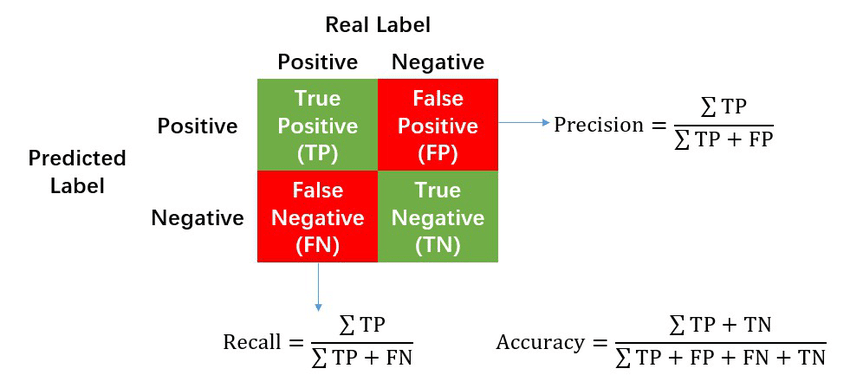

In [68]:
# Model |	Employee | outcome
# 0	    |    0	     |  stay
# 0	    |    1	     |  go
# 1	    |    0	     |  stay
# 1	    |    1	     |  go

* **Precision** : **You Predicted x True out of which how many a actually true.** Ability to correctly identify positive instances out of all instances that the model predicted as positive. 
                    
* **Recall**    : **There are x actual true value how many did you correctly predicted True.** Ability to identify all positive instances correctly out of all true positive instances in the data set.  



When the recall is high, it means that the model is correctly identifying a high proportion of positive instances in the data set. This is generally desirable in many applications where the goal is to identify as many true positive instances as possible, even at the expense of higher false positives.



**If you want to keep all potential chrning employee from leaving at all cost go for high Recall** . Now some no churning employee will get classified as churning due to high recall and get some good care.

**If you want to wanna know who exactly is leaving go for high precision** Now only churning employee we'll be classified churning.

Now there comes trade-off between **RECALL** and **PRECISION**. when one goes up other goes down. **F1 score** is a sweet spot for both the metrics if you want both.

**Finally we will go for High recall while not losing precision much**

# FineTuning Model

In [69]:
# code to Grid search cv for a knearest neighbour model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def all_combo(x:dict):
    result = 1
    for i in x.values():
        result *= len(i)
    return result

def random_search(model, param, X_train, y_train, X_test, y_test, cv:int = 5, n_iter:int = 20, random:bool=True):
    n_iter= all_combo(param) if random==False else n_iter
    grid_search = RandomizedSearchCV(model, param,n_iter=n_iter, cv=cv, n_jobs=-1) if random else GridSearchCV(model, param, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f'{grid_search.best_params_=}')
    print(f'{grid_search.best_score_=}')
    y_pred = grid_search.predict(X_test)
    
    score_ = calculate_results(y_test, y_pred, model_name = model)
    display(score_)
    print("\nConfusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    return grid_search

In [70]:
xtrain, xtest,ytrain, ytest = train_test_split(x,y, test_size=.1, random_state=22)

## 1. KNN finetuning

In [71]:

knn_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}


In [72]:
knn_grid = random_search(KNeighborsClassifier(),  knn_params ,xtrain, ytrain, xtest, ytest)

grid_search.best_params_={'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
grid_search.best_score_=0.824382415630242


{'model': KNeighborsClassifier(),
 'accuracy': 83.05905130687319,
 'precision': 0.8394668147818405,
 'recall': 0.8305905130687319,
 'f1': 0.8301132741385369,
 'discription': None}


Confusion Matrix
[[410 127]
 [ 48 448]]


In [73]:
plot_grid_search(knn_grid)
table_grid_search(knn_grid)

/home/t/c-project/churn modelling/funcyou/grid_search_utils.py:176: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



mean_test_score,mean_fit_time,mean_score_time,param_weights,param_n_neighbors,param_metric
0.824382,0.003170,0.412166,distance,7,manhattan


## 2. Adaboost Finetuning

In [74]:
ada_params = {
    'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30],
    'learning_rate': [0.97 + x / 100 for x in range(8)],
    'algorithm': ['SAMME', 'SAMME.R'],
}

In [75]:
adaboost_grid  = random_search(AdaBoostClassifier(),  ada_params ,xtrain, ytrain, xtest, ytest)

grid_search.best_params_={'n_estimators': 30, 'learning_rate': 0.98, 'algorithm': 'SAMME.R'}
grid_search.best_score_=0.8162042974827607


{'model': AdaBoostClassifier(),
 'accuracy': 80.25169409486931,
 'precision': 0.8072367405709635,
 'recall': 0.8025169409486931,
 'f1': 0.8023344153616809,
 'discription': None}


Confusion Matrix
[[406 131]
 [ 73 423]]


In [76]:
adaboost_grid.best_score_

0.8162042974827607

In [77]:
plot_grid_search(adaboost_grid)
table_grid_search(adaboost_grid)

/home/t/c-project/churn modelling/funcyou/grid_search_utils.py:176: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



mean_test_score,mean_fit_time,mean_score_time,param_n_estimators,param_learning_rate,param_algorithm
0.816204,0.484230,0.022286,30,0.980000,SAMME.R


## 3. XGBRF finetuning

In [78]:
xgbrf_params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 'n_estimators'     : range(100, 301, 50),
 "max_depth"        : range(19,35, 2),
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [79]:
xgbrf_grid  = random_search(XGBRFClassifier(),  xgbrf_params ,xtrain, ytrain, xtest, ytest)

grid_search.best_params_={'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 21, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.5}
grid_search.best_score_=0.8515006563362943


{'model': XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bytree=None,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                 grow_policy=None, importance_type=None,
                 interaction_constraints=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 objective='binary:logistic', predictor=None, random_state=None,
                 reg_alpha=None, ...),
 'accuracy': 84.31752178121975,
 'precision': 0.8436973934071977,
 'recall': 0.8431752178121975,
 'f1': 0.8432340382814072,
 'discription': None}


Confusion Matrix
[[448  89]
 [ 73 423]]


In [80]:
xgbrf_grid.best_score_

0.8515006563362943

In [81]:
plot_grid_search(xgbrf_grid)
table_grid_search(xgbrf_grid)

/home/t/c-project/churn modelling/funcyou/grid_search_utils.py:176: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



mean_test_score,mean_fit_time,mean_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree
0.851501,2.583977,0.029354,100,1,21,0.300000,0.400000,0.500000


## 4. XGB finetuning

In [82]:
xgb_params = {
    'n_estimators': range(100,301, 50),
    'max_depth': range(20,40,2),
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': range(2,10)
    }

In [83]:
xgb_grid  = random_search(XGBClassifier(),  xgb_params ,xtrain, ytrain, xtest, ytest)

grid_search.best_params_={'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 32, 'learning_rate': 0.05}
grid_search.best_score_=0.851823005180627


{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'accuracy': 84.80154888673765,
 'precision': 0.8480844169509518,
 'recall': 0.8480154888673765,
 'f1': 0.8479152296737915,
 'discription': None}


Confusion Matrix
[[465  72]
 [ 85 411]]


In [84]:
xgb_grid.best_score_

0.851823005180627

In [85]:
plot_grid_search(xgb_grid)
table_grid_search(xgb_grid)

/home/t/c-project/churn modelling/funcyou/grid_search_utils.py:176: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis="index")`



mean_test_score,mean_fit_time,mean_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate
0.851823,10.462344,0.046012,200,3,32,0.050000


# Final Model : Finetuned XGB

Now for the FInal model i want to see shap values wrt columns names, for that we have to keep columns name , so using column transformer won't be helpful as it returns numpy array and not pandas df,
we have to preprocess the data manually.

In [86]:
column_transformer.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['gender', 'seniorcitizen', 'partner',
                                  'dependents', 'phoneservice',
                                  'paperlessbilling']),
                                ('ordinal', OrdinalEncoder(),
                                 ['multiplelines', 'internetservice',
                                  'onlinesecurity', 'onlinebackup',
                                  'deviceprotection', 'techsupport',
                                  'streamingtv', 'streamingmovies', 'contract',
                                  'paymentmethod']),
                                ('power_transform', PowerTransformer(),
                                 ['tenure', 'monthlycharges', 'totalcharges'])])>

In [87]:
from utils.utils import get_feature_names

In [88]:
import sklearn
import warnings

In [89]:
feature_names = get_feature_names(column_transformer)
feature_names, len(feature_names)

/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/home/t/c-project/churn modelling/utils/utils.py:39: UserWarning:

Transformer ordinal (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available

/home/t/c-project/churn modelling/utils/utils.py:39: UserWarning:

Transformer power_transform (type PowerTransformer) does not provide get_feature_names. Will return input column names if available



(['onehot__x0_male',
  'onehot__x1_yes',
  'onehot__x2_yes',
  'onehot__x3_yes',
  'onehot__x4_yes',
  'onehot__x5_yes',
  'ordinal__multiplelines',
  'ordinal__internetservice',
  'ordinal__onlinesecurity',
  'ordinal__onlinebackup',
  'ordinal__deviceprotection',
  'ordinal__techsupport',
  'ordinal__streamingtv',
  'ordinal__streamingmovies',
  'ordinal__contract',
  'ordinal__paymentmethod',
  'power_transform__tenure',
  'power_transform__monthlycharges',
  'power_transform__totalcharges'],
 19)

In [90]:
x.shape, y.shape

((10326, 19), (10326,))

In [91]:
# making pandas df from oversampled and column transformed data
xdf = pd.DataFrame(x, columns=feature_names)
xdf.head()

,onehot__x0_male,onehot__x1_yes,onehot__x2_yes,onehot__x3_yes,onehot__x4_yes,onehot__x5_yes,ordinal__multiplelines,ordinal__internetservice,ordinal__onlinesecurity,ordinal__onlinebackup,ordinal__deviceprotection,ordinal__techsupport,ordinal__streamingtv,ordinal__streamingmovies,ordinal__contract,ordinal__paymentmethod,power_transform__tenure,power_transform__monthlycharges,power_transform__totalcharges
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.649511,-1.159996,-1.810069
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.294467,-0.241345,0.254257
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.500657,-0.344532,-1.386091
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.644481,-0.732875,0.233220
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.500657,0.211884,-1.248808


In [92]:
xgb_grid.best_params_


{'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 32,
 'learning_rate': 0.05}

In [93]:

# train XGBoost model
model = XGBClassifier(
    n_estimators = xgb_grid.best_params_['n_estimators'],
    min_child_weight = xgb_grid.best_params_['min_child_weight'],
    max_depth = xgb_grid.best_params_['max_depth'],
    learning_rate = xgb_grid.best_params_['learning_rate']
    )

model.fit(x,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [94]:
# x_sampled = xdf.sample(2000)
x_sampled = xdf.sample(1)

In [95]:
shap.initjs()


In [96]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_sampled)

/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [97]:
shapl = explainer(x_sampled)

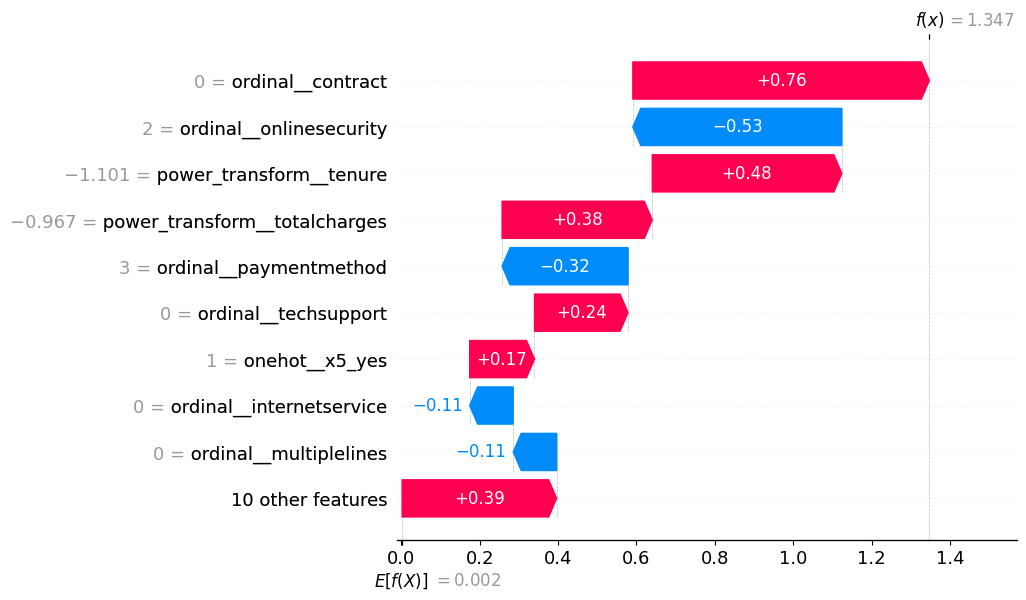

In [98]:
shap.plots.waterfall(shapl[0])

In [114]:
shap_values[0,:].shape

(19,)

In [99]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_sampled.iloc[0,:])


In [100]:
## This cell takes too much time if all the data is used : use for small samples.
# shap.force_plot(explainer.expected_value, shap_values, x_sampled)


/home/t/miniconda3/envs/tf_new/lib/python3.9/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



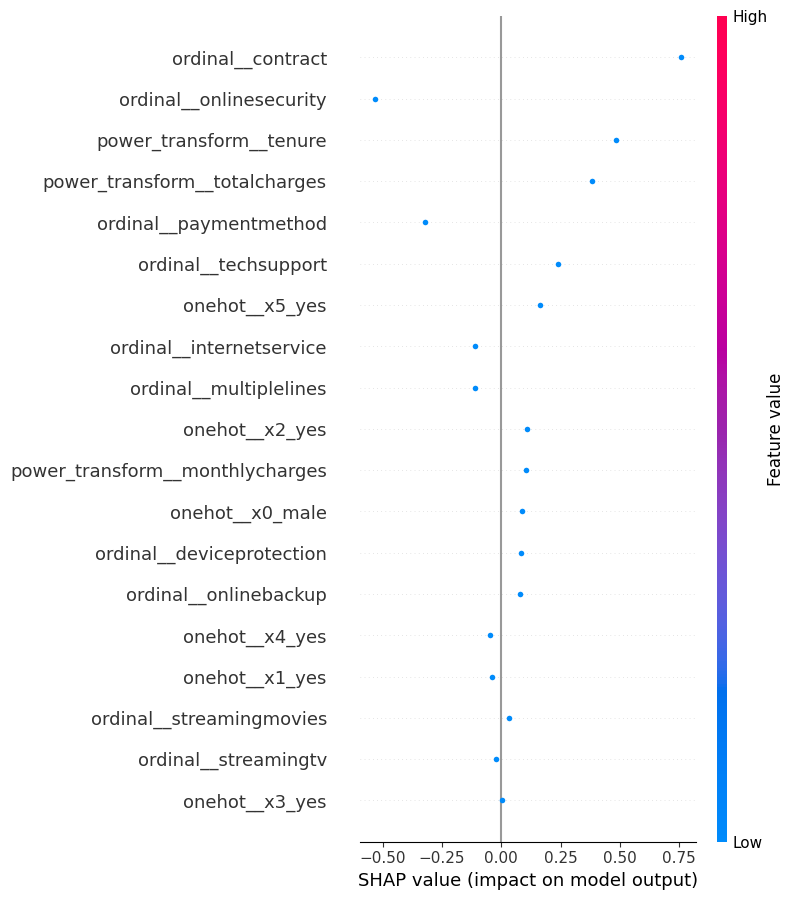

In [101]:
shap.summary_plot(shap_values, x_sampled)

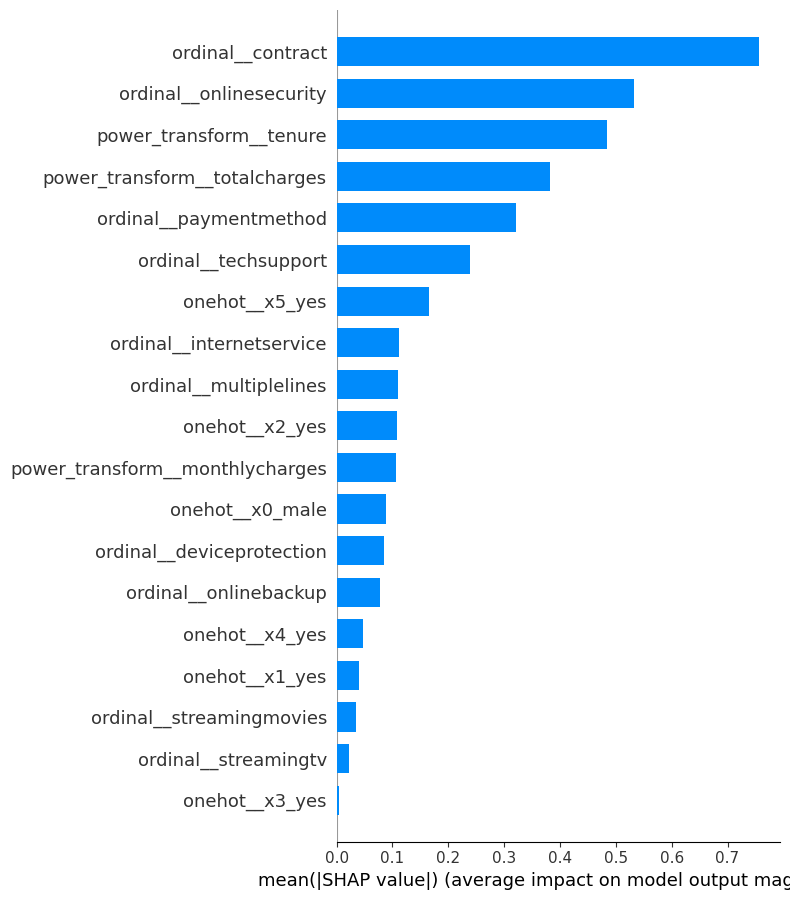

In [102]:
shap.summary_plot(shap_values, x_sampled, plot_type="bar")


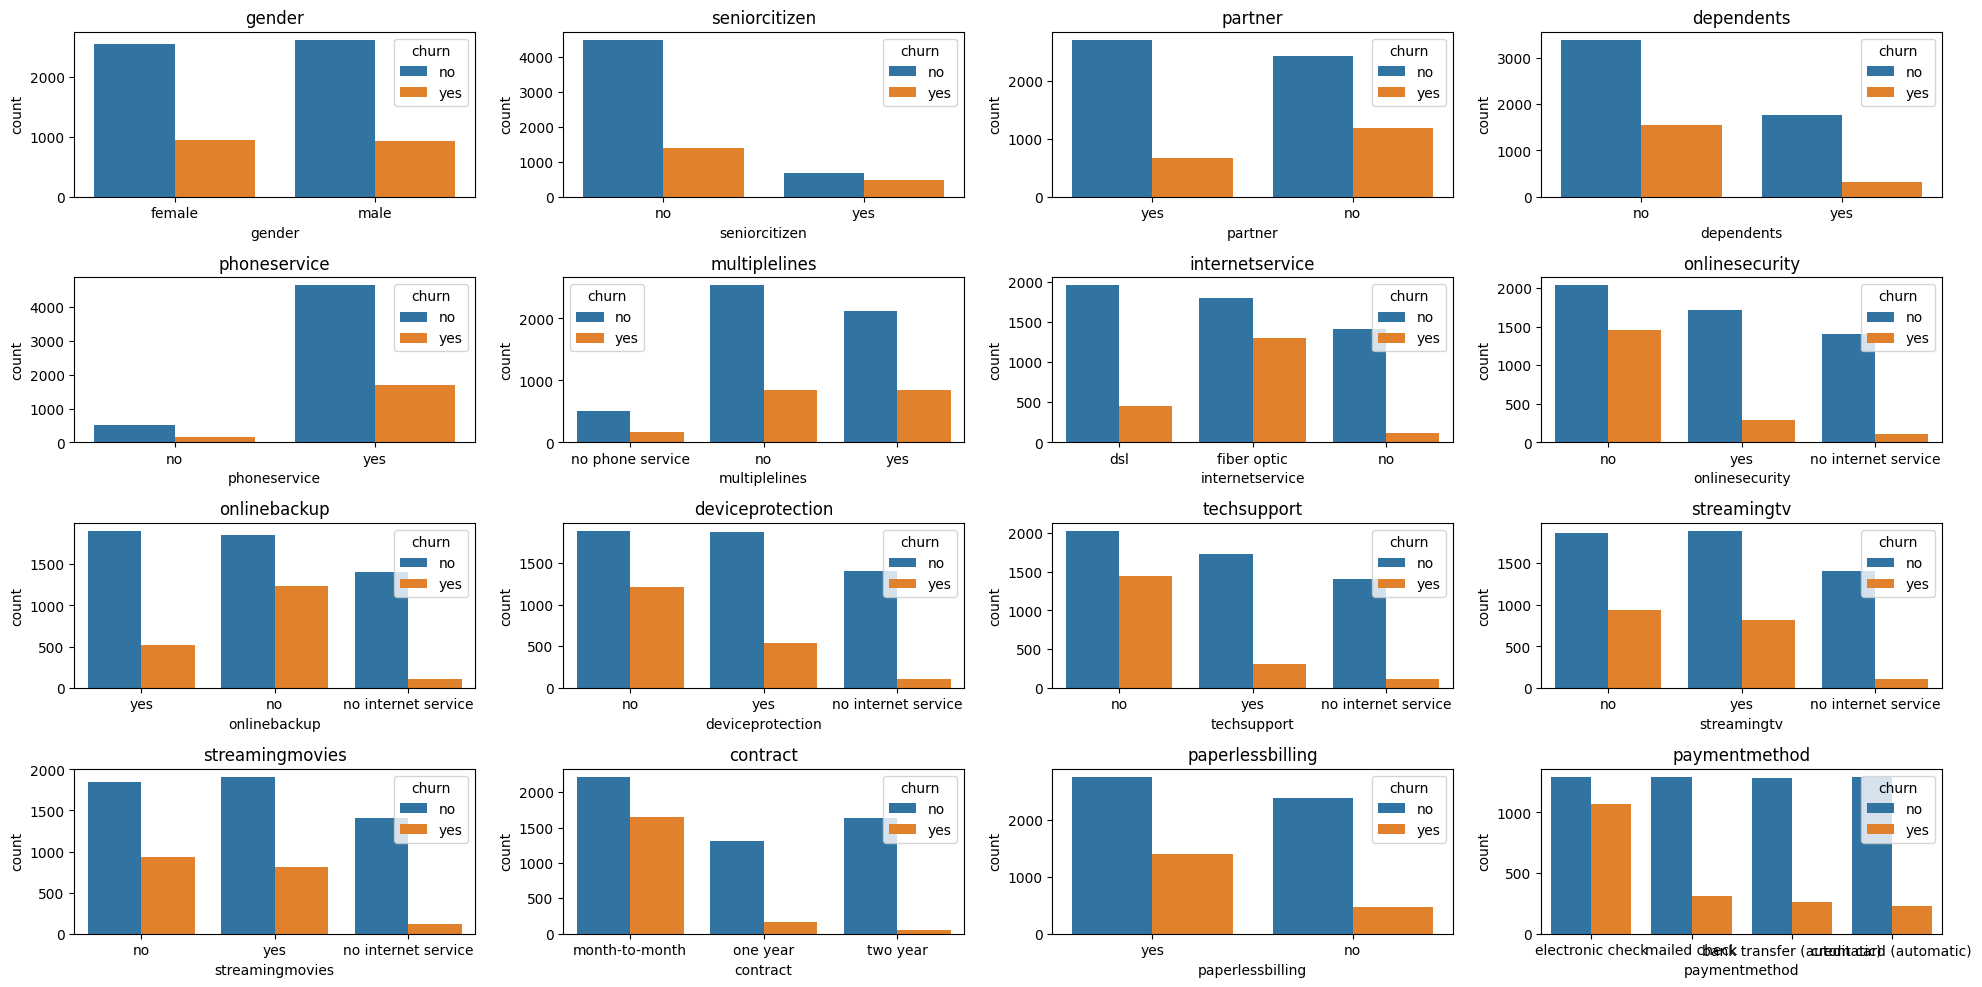

In [103]:
plt.figure(figsize = (20,12))
for n, col in enumerate(categorial_columns,1):
    plt.subplot(5,4,n)
    sns.countplot(data = data, x=col, hue='churn')
    plt.title(col)
plt.tight_layout()

# Saving the Model

In [104]:
#save model

filename='./model/finalxgbclassifier.joblib'

os.makedirs('model',exist_ok = True)
joblib.dump(model, filename) 


['./model/finalxgbclassifier.joblib']

In [105]:
data.columns, len(data.columns)

(Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
        'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
        'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
        'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
        'monthlycharges', 'totalcharges', 'churn'],
       dtype='object'),
 20)

In [106]:
input_columns = list(data.columns)
input_columns.remove('churn')

column_structure = {

    'input_columns': input_columns,
    'two_value_categorial_columns' : two_value_categorial_columns,
    'more_value_categorial_columns': more_value_categorial_columns,
    'numerical_columns': numerical_columns,
    'categories_with_values': categories_with_values

}


In [107]:
# write input_columns variable to yaml file

import toml

toml_string = toml.dumps(column_structure)  # Output to a string

toml_filename = "./config.toml"
with open(toml_filename, "w") as toml_file:
    toml.dump(column_structure, toml_file)

In [108]:
# saving the column transformer
joblib.dump(column_transformer, filename='./model/column_transformer.joblib')

['./model/column_transformer.joblib']

In [109]:
sample1000 = data.sample(1000)
sample1000.to_csv('./model/sample1000.csv')